In [4]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os
from pprint import pprint

from earthpy.spatial import stack as es_stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import block_reduce

# mapping
import cartopy
import cartopy.crs as ccrs

from matplotlib import colors
import matplotlib.gridspec as gridspec

import pandas as pd
import calendar
import imageio # animation
from helpers import *
from affine import Affine
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)



# write out the rasters
def write_out(xarr, fname, meta_file):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None

def write_out_agg(xarr, fname, meta_file, agg=0.25):
    
    # load metadata
    with open(meta_file, 'rb') as fp:
        meta = pickle.load(fp)
        
    if agg != 0.25:

        # restructure affine
        orig_size = meta['transform'].a
        agg_size = agg
        factor = agg_size/orig_size

        # calculate the new rows/cols
        new_height = int(np.floor_divide(meta['height'], factor))
        new_width = int(np.floor_divide(meta['width'], factor))

        # calculate the new center point for the upper left
        new_ul_x = meta['transform'].c - orig_size + agg_size/2
        new_ul_y =  meta['transform'].f + orig_size - agg_size/2

        # generate the new transform
        new_transform = Affine(agg_size, 0.0, new_ul_x, 
                               0.0, -agg_size, new_ul_y)

        # dictionary to update the metadata
        update_dict = {'height': new_height,
                       'width': new_width,
                      'transform': new_transform}

        meta.update(update_dict)

    with rio.open(fname, 'w', **meta) as dst:
        dst.write(xarr[np.newaxis,...].astype(np.float32))
        
    return None



PyTables is not installed. No support for HDF output.


In [5]:
raster_folder = r"../vars/grid_0_25_degree_vars/" # data refresh!
raster_folder = r"../vars/CSV_nocorn_grid_0_25_degree_vars/" # data refresh! fixed mis classifications
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
year = 2012

day_files, night_files = get_fire_year_files(raster_folder, var, year)

In [6]:
# verify
for fi in day_files:
    print(fi)
    
print()

# verify
for fi in night_files:
    print(fi)

../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_March_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_April_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_May_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_June_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_July_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_August_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_September_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_October_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_November_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_December_2012.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_January_2013.tif
../vars/CSV_nocorn_grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_February_2013.tif

../vars/CSV_nocorn_grid_0

In [7]:
# open and resample to 2.5 deg res
from skimage.transform import resize

with rio.open('../vars/aqua-terra-overpasses-per-day_0.25-degree-grid.tif') as src:
    op_0_25 = src.read()[0]
    print(src.profile)
    
    op_0_25[op_0_25<=0] = 1
    op_0_25_prof = src.profile
    
with rio.open('../overpass_corrections/2003-2018_day_overpass-count.tif') as src:
    day_op = src.read()
    day_op = np.ma.masked_equal(day_op, 0)
    
with rio.open('../overpass_corrections/2003-2018_night_overpass-count.tif') as src:
    night_op = src.read()
    night_op = np.ma.masked_equal(night_op, 0)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 1440, 'height': 721, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(0.25, 0.0, -179.875,
       0.0, -0.25, 89.875), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}


In [8]:
def calc_fire_season_agg_oc(files_array, agg_fac=1):
    
    # stack the files
    arr,_ = es_stack(files_array, nodata=-32768)
    op_oc = np.ma.masked_equal(op_0_25*30.44/2, 0)
    arr *= op_oc
    arr = np.ma.masked_equal(arr, -32768)
    
    p10 = np.nanmedian(arr, axis=0)*0.1
    #print(f'p10: {np.nansum(p10)}')
    #arr*= op_oc #op_0_25*30.44/2 # number of days per year, divide by two for night/day. NEED TO DO PER MONTH... avg. days per mo?
    
    arr_list = []
    if agg_fac > 1:
        
        for a in arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        arr = np.array(arr_list)
    
    
    
    #rr[arr == 0] = np.nan
    # take the mean across the time axis
    p10 = np.nanmean(arr, axis=0)*0.1
    #print(f'after agg p10: {np.nansum(p10)}')
    
    # sum across time axis
    fs_arr = arr > p10    
    
    fs_sum = np.ma.sum(fs_arr, axis=0)
    fs_sum = np.ma.masked_equal(fs_sum, 0)
    return fs_sum
    

In [9]:
# account for the updated overpass corrections with month-year combos
month_dict = {'January': '01',
             'February': '02',
             'March': '03',
             'April': '04',
             'May': '05',
             'June': '06',
             'July': '07',
             'August': '08',
             'September':'09',
             'October':'10',
             'November': '11',
             'December':'12'}

days_fl, nights_fl=[],[]
day_an, night_an = [],[]
day_op_stack, night_op_stack = [],[]
day_op_stack_arr, night_op_stack_arr = [],[]
agg = 4
op_dir = '../overpass_corrections/year-month'
for year in range(2003,2019):

    day_files = glob(raster_folder + f'{var}/*_D_*{year}.tif')
    night_files = glob(raster_folder + f'{var}/*_N_*{year}.tif')
    
    day_arr,_ = es_stack(day_files, nodata=-32768)
    night_arr, _ = es_stack(night_files, nodata=-32768)
    
    ds = np.ma.sum(day_arr, axis=0) #*op_oc
    ns = np.ma.sum(night_arr, axis=0) #*op_oc
    
    day_an.append(ds[np.newaxis,...])
    night_an.append(ns[np.newaxis, ...])
    
    
    # overpass rasters
    day_op_ls = [os.path.join(op_dir,'{}-{}_day_overpass-count.tif'.format(year,month_dict[os.path.basename(fi).split('_')[-2]])) for fi in day_files]
    night_op_ls = [os.path.join(op_dir,'{}-{}_night_overpass-count.tif'.format(year,month_dict[os.path.basename(fi).split('_')[-2]])) for fi in night_files]
    
    day_op_arr,_ = es_stack(day_op_ls, nodata=0)
    night_op_arr, _ = es_stack(night_op_ls, nodata=0)
    
    day_op_stack_arr.append(day_op_arr[np.newaxis,...])
    night_op_stack_arr.append(night_op_arr[np.newaxis,...])
    
    day_op_sum = np.ma.sum(day_op_arr, axis=0)
    night_op_sum = np.ma.sum(night_op_arr, axis=0)
    
    day_op_stack.append(day_op_sum[np.newaxis,...])
    night_op_stack.append(night_op_sum[np.newaxis,...])
    
    

In [10]:
day_sum = np.ma.concatenate(day_an, axis=0)
print(day_sum.shape)
day_sum = np.ma.sum(day_sum, axis=0)
night_sum = np.ma.concatenate(night_an, axis=0)
night_sum = np.ma.sum(night_sum, axis=0)

# full record overpass
day_sum /= day_op[0]
night_sum /= night_op[0]

perc_day_total = day_sum / (day_sum + night_sum)
perc_night_total = night_sum / (day_sum + night_sum)

(16, 721, 1440)


In [11]:
perc_night_total.min(), perc_night_total.max(), type(day_sum), type(night_sum), perc_night_total.shape

(0.0, 1.0, numpy.ma.core.MaskedArray, numpy.ma.core.MaskedArray, (721, 1440))

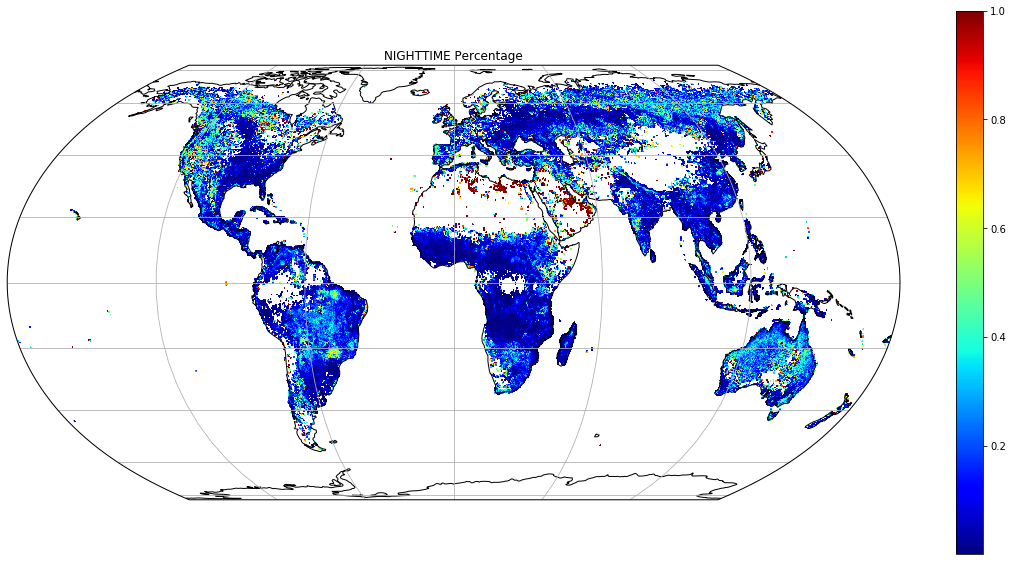

In [12]:
gen_plot_xarr(perc_night_total, raster_folder, title='NIGHTTIME Percentage');

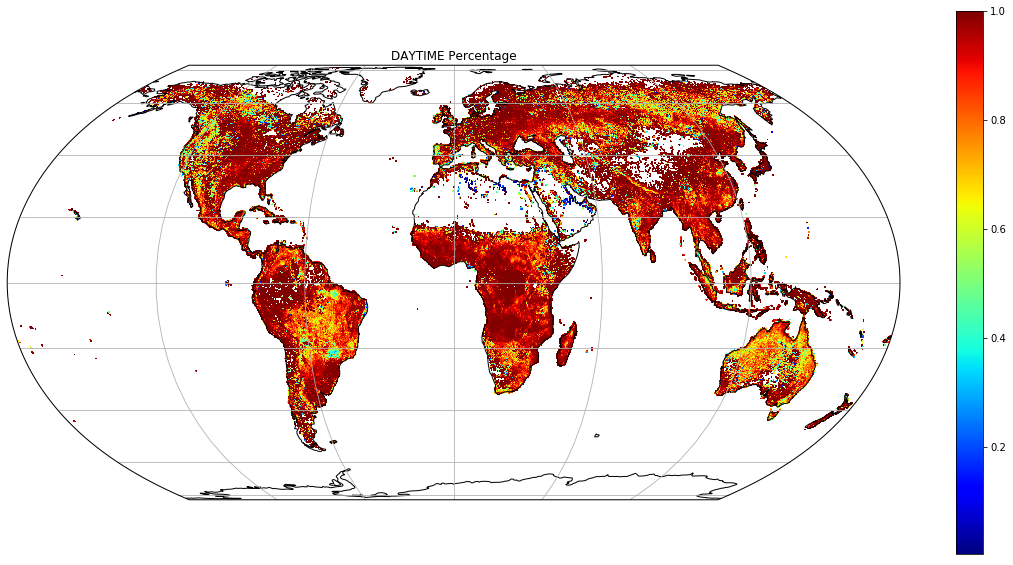

In [13]:
gen_plot_xarr(perc_day_total, raster_folder, title='DAYTIME Percentage');

In [14]:
# fn = r'D:\projects\RD\night_fire\figs\global\perc_night_total.tif'
# write_out(perc_night_total, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# fn = r'D:\projects\RD\night_fire\figs\global\perc_day_total.tif'
# write_out(perc_day_total, fn, 'climate_grid_meta_0_25_wgs84.pickle')

# for fixing mis classifications
fn = r'D:\projects\RD\night_fire\figs\global\SOLARELEV_nocorn_perc_night_total.tif'
write_out(perc_night_total, fn, 'climate_grid_meta_0_25_wgs84.pickle')

fn = r'D:\projects\RD\night_fire\figs\global\SOLARELEV_nocorn_perc_day_total.tif'
write_out(perc_day_total, fn, 'climate_grid_meta_0_25_wgs84.pickle')

## aggregate

In [15]:
days_fl, nights_fl=[],[]
day_an_agg, night_an_agg = [],[]
agg = 4
for i,year in enumerate(range(2003,2019)):

    day_files = glob(raster_folder + f'{var}/*_D_*{year}.tif')
    night_files = glob(raster_folder + f'{var}/*_N_*{year}.tif')
    
    day_arr,_ = es_stack(day_files, nodata=-32768)
    night_arr, _ = es_stack(night_files, nodata=-32768)
        
    day_arr /= day_op_stack_arr[i][0]
    night_arr /= night_op_stack_arr[i][0]
    
    arr_list = []
    if agg > 1:
        
        arr_list = []
        for a in day_arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        day_arr = np.array(arr_list)
        
        arr_list = []
        for a in night_arr:
            a[a.mask] = 0
            temp = block_reduce(a, (agg, agg), func=np.ma.sum)
            arr_list.append(np.ma.masked_equal(temp, 0))
            
        night_arr = np.array(arr_list)
    
    day_an_agg.append(day_arr)
    night_an_agg.append(night_arr)
    
    continue

In [16]:
day_sum_agg = np.ma.concatenate(day_an_agg, axis=0).sum(axis=0)
night_sum_agg = np.ma.concatenate(night_an_agg, axis=0).sum(axis=0)
perc_day_total_agg = day_sum_agg / (day_sum_agg + night_sum_agg)
perc_night_total_agg = night_sum_agg / (day_sum_agg + night_sum_agg)

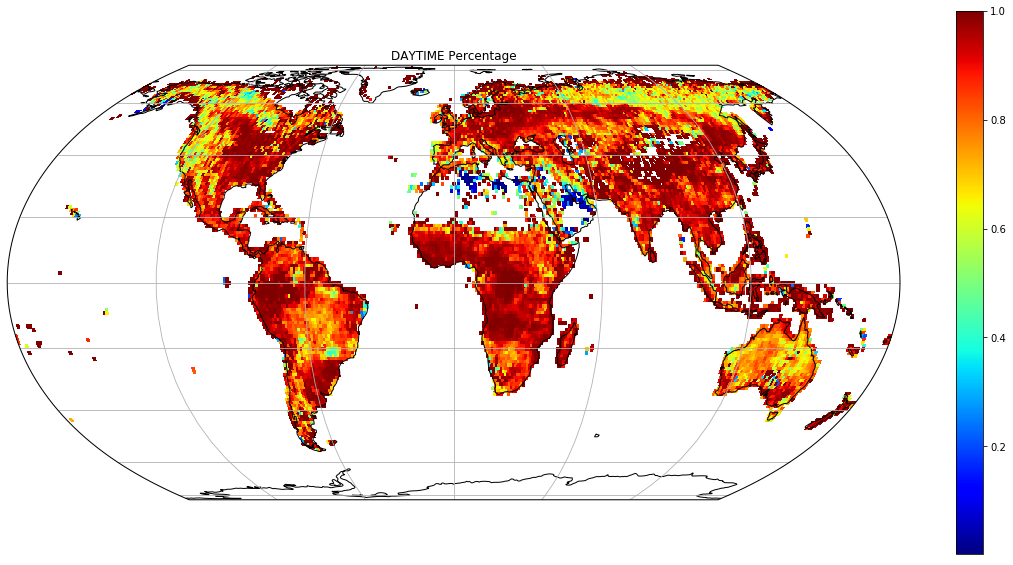

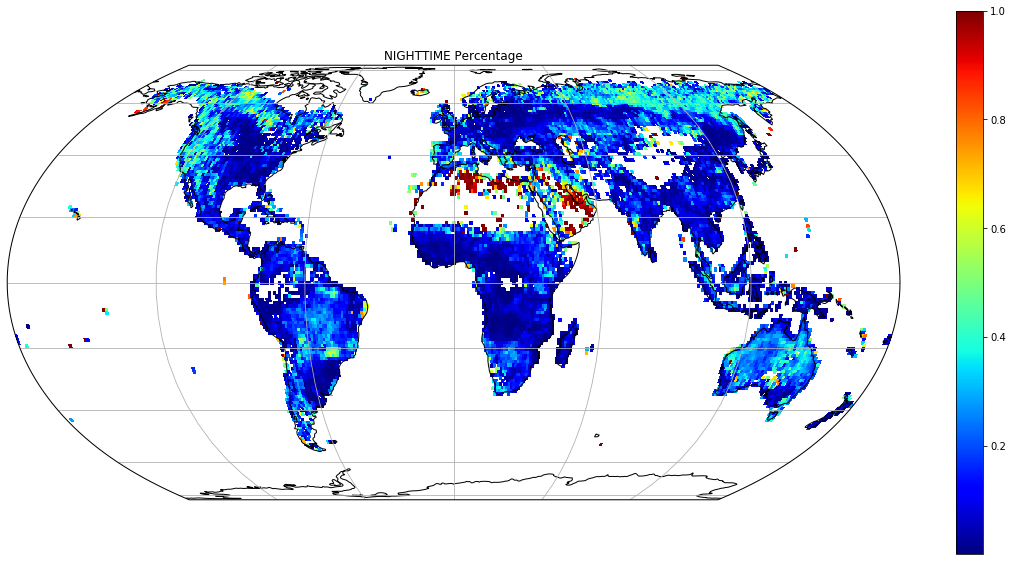

In [17]:
gen_plot_xarr(perc_day_total_agg, raster_folder, title='DAYTIME Percentage', agg=agg);
gen_plot_xarr(perc_night_total_agg, raster_folder, title='NIGHTTIME Percentage', agg=agg);


In [18]:
fn = r'D:\projects\RD\night_fire\figs\global\AGG_1deg_SOLARELEV_nocorn_perc_night_total.tif'
write_out_agg(perc_night_total_agg, fn, 'climate_grid_meta_0_25_wgs84.pickle', agg=1.0)

fn = r'D:\projects\RD\night_fire\figs\global\AGG_1deg_SOLARELEV_nocorn_perc_day_total.tif'
write_out_agg(perc_day_total_agg, fn, 'climate_grid_meta_0_25_wgs84.pickle', agg=1.0)

## mask with GLDAS

In [19]:
print(agg)

data = perc_night_total_agg
agg_fact=agg
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta

tform = meta['transform']
#num_x = meta['width']
#num_y = meta['height']

num_x = data.shape[1]
num_y = data.shape[0]

# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
lon2d, lat2d = np.meshgrid(tlon, tlat)


# make data into xarray with location
xdata = xr.DataArray(data, coords=[tlat, tlon], dims=['lat', 'lon'])
xdata = xr.where(xdata == 0, np.nan, xdata)

4


In [20]:
gldas_fi = '../GLDAS/GLDASp4_domveg_1d.tif'
with rio.open(gldas_fi) as src:
    gldas_prof = src.profile
    gldas_arr = src.read(1)
    
xr_gldas = xr.open_rasterio(gldas_fi)

In [21]:
gldas_burn_cond = (gldas_arr==0) | \
             (gldas_arr==13) | (gldas_arr==15) | (gldas_arr==16) | \
             (gldas_arr==18) | (gldas_arr==19) | (gldas_arr==20) 

# Max's palette
gldas_burn_cond = (gldas_arr==0) | (gldas_arr==3) | (gldas_arr==11) | (gldas_arr==13) | (gldas_arr>=15)

# gldas_mask = np.where((gldas_arr==0) | (gldas_arr==12) | (gldas_arr==14), 0, 1)
gldas_mask = np.where(gldas_burn_cond, 0, 1)
gl_nc = xdata.values[:150,:].copy()

gl_nc_mask = gl_nc * gldas_mask
gl_nc.shape, gldas_mask.shape, gldas_arr.shape

# print(np.unique(gldas_arr[~gldas_burn_cond]))
# plt.imshow(np.where(gldas_burn_cond, np.nan, gldas_arr))

((150, 360), (150, 360), (150, 360))

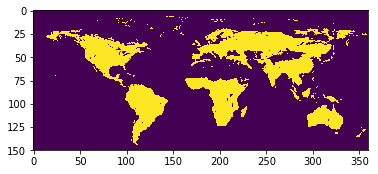

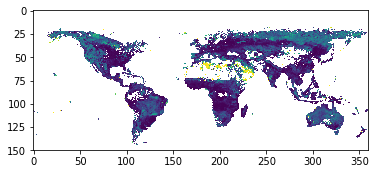

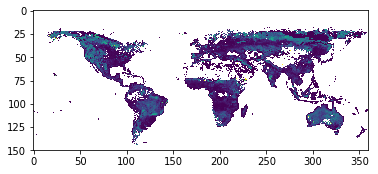

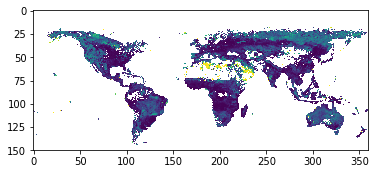

In [22]:
plt.imshow(gldas_mask)
plt.show()
plt.imshow(gl_nc)
plt.show()
plt.imshow(gl_nc_mask)
plt.show()
plt.imshow(xdata.values[:150,:])

In [23]:
np.nansum(xdata.values[:150,:] - gl_nc_mask)
from scipy.signal import medfilt

In [24]:
xdata_gl = xdata.copy()
gl_nc_mask_nan = np.where(gl_nc_mask == 0, np.nan, gl_nc_mask)
xdata_gl.values[:150,:] = gl_nc_mask_nan

# # mask the day sum agg and night sum agg
# day_sum_agg_gl = day_sum_agg.copy()
# day_sum_agg_gl[:150,:] = np.ma.where((gldas_arr==0) | (gldas_arr==12) | (gldas_arr==14), 0, day_sum_agg[:150,:])
# night_sum_agg_gl = night_sum_agg.copy()
# night_sum_agg_gl[:150,:] = np.ma.where((gldas_arr==0) | (gldas_arr==12) | (gldas_arr==14), 0, night_sum_agg[:150,:])

# day_sum_lat_agg_gl = day_sum_agg_gl.filled(0).sum(axis=1)
# night_sum_lat_agg_gl = night_sum_agg_gl.filled(0).sum(axis=1)

# # day_sum_lat_agg = np.ma.sum(day_sum_agg, axis=1)
# # night_sum_lat_agg = np.ma.sum(night_sum_agg, axis=1)

# perc_night_lat_agg_gl = night_sum_lat_agg_gl / (day_sum_lat_agg_gl + night_sum_lat_agg_gl)
# perc_night_lat_agg_gl = np.ma.MaskedArray(perc_night_lat_agg_gl, mask=np.isnan(perc_night_lat_agg_gl))

# perc_day_lat_agg_gl = day_sum_lat_agg_gl / (day_sum_lat_agg_gl + night_sum_lat_agg_gl)
# perc_day_lat_agg_gl = np.ma.MaskedArray(perc_day_lat_agg_gl, mask=np.isnan(perc_day_lat_agg_gl))

# sm_perc_gl = medfilt(perc_night_lat_agg_gl.squeeze(), 7)
# sm_perc_gl = np.ma.MaskedArray(sm_perc_gl, mask=perc_night_lat_agg.mask)
# plt.plot(sm_perc_gl)
# plt.plot(perc_night_lat_agg_gl, alpha=0.4)
# plt.show()


## plot only with map, no grid lines, and colorbar a la John A.

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99] (100,)


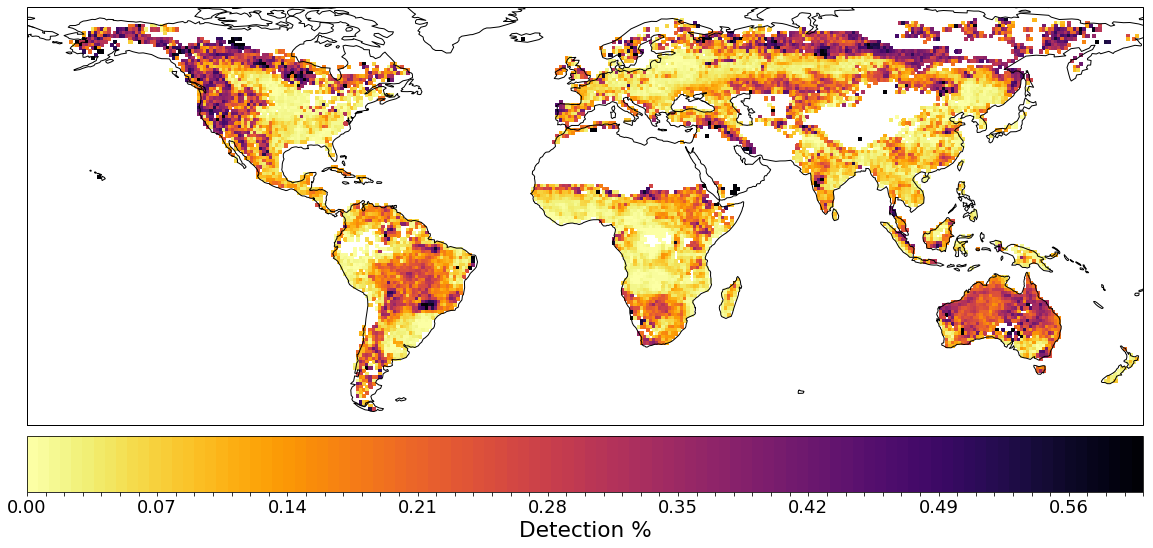

In [25]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()


#del cmap
# try function
c = 'viridis_r'
c = 'inferno_r'
#cmap, bounds = discrete_cmap(20, c)

base = plt.cm.get_cmap(c)
z_t_1_fact = 0.01
bounds = np.arange(0,1,z_t_1_fact)
print(bounds, bounds.shape)
color_list = base(bounds)
N = bounds.shape[0]
cmap_name = base.name + str(N)

# if  'viridis' in c:
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)
# else:
#     cmap = base.from_list(cmap_name, color_list, N)
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)


# cf4 = xdata_gl.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
cf4 = xdata_gl.plot(ax=ax, vmax=0.6, transform=ccrs.PlateCarree(), cmap=cmap,  add_colorbar=False, extend='neither')
ax.set_ylim(-60, 75)

# ax.set_title('NIGHTTIME %')

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    boundaries=bounds,
#                    cmap=cmap,
#                    norm=norm,
#                    ticks=bounds)
cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
                   cmap=cmap,
                   ticks=bounds,
                  extend='neither')

if bounds.shape[0] > 10:
       
    n = 7  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(cb4.ax.xaxis.get_ticklabels()) if i % n != 0]
    
cb4.set_label('Detection %', size='large')

plt.savefig(f'C:/users/jomc9287/desktop/test_gldasmask_burnable_{c}_maxpalette_fullOC.png')
plt.show()



[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99] (100,)


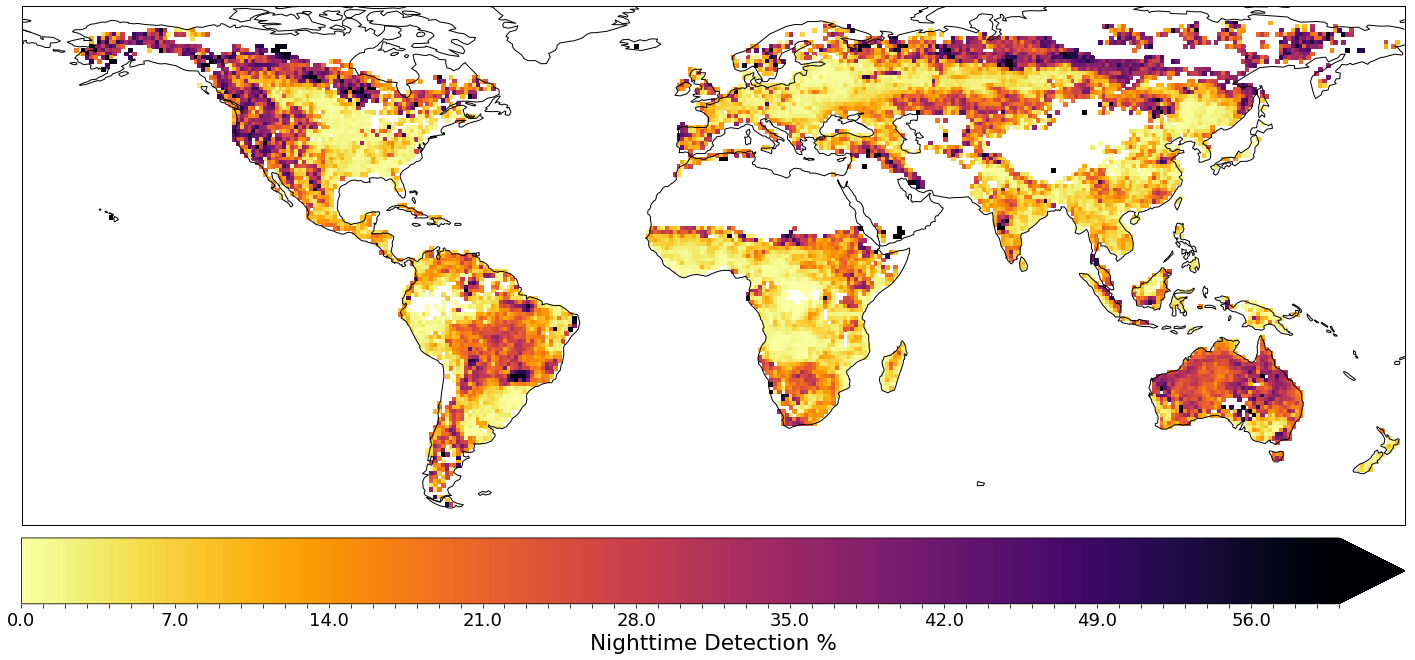

In [26]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines()


#del cmap
# try function
c = 'viridis_r'
c = 'inferno_r'
#cmap, bounds = discrete_cmap(20, c)

base = plt.cm.get_cmap(c)
z_t_1_fact = 0.01
bounds = np.arange(0,1,z_t_1_fact)
print(bounds, bounds.shape)
color_list = base(bounds)
N = bounds.shape[0]
cmap_name = base.name + str(N)

# if  'viridis' in c:
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)
# else:
#     cmap = base.from_list(cmap_name, color_list, N)
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)


# cf4 = xdata_gl.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
cf4 = xdata_gl.plot(ax=ax, vmax=0.6, transform=ccrs.PlateCarree(), cmap='inferno_r',  add_colorbar=False, extend='max')
ax.set_ylim(-60, 75)

# ax.set_title('NIGHTTIME %')

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    boundaries=bounds,
#                    cmap=cmap,
#                    norm=norm,
#                    ticks=bounds)

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    cmap=cmap,
#                    ticks=bounds,
#                   extend='max')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02,
                  extend='max',
                  ticks=bounds[bounds<=0.6])

# show as percentage
cb4.ax.set_xticklabels(['{0:.1f}'.format(b*100) for b in bounds[bounds<=0.6]], rotation=0)

if bounds.shape[0] > 10:
       
    n = 7  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(cb4.ax.xaxis.get_ticklabels()) if i % n != 0]
    
cb4.set_label('Nighttime Detection %', size='large')

plt.tight_layout()
plt.savefig(f'C:/users/jomc9287/desktop/extend_gldasmask_burnable_{c}_fullOC_CONUS.png')
plt.show()

maintain all of GLDAS values except ocean and missing

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99] (100,)


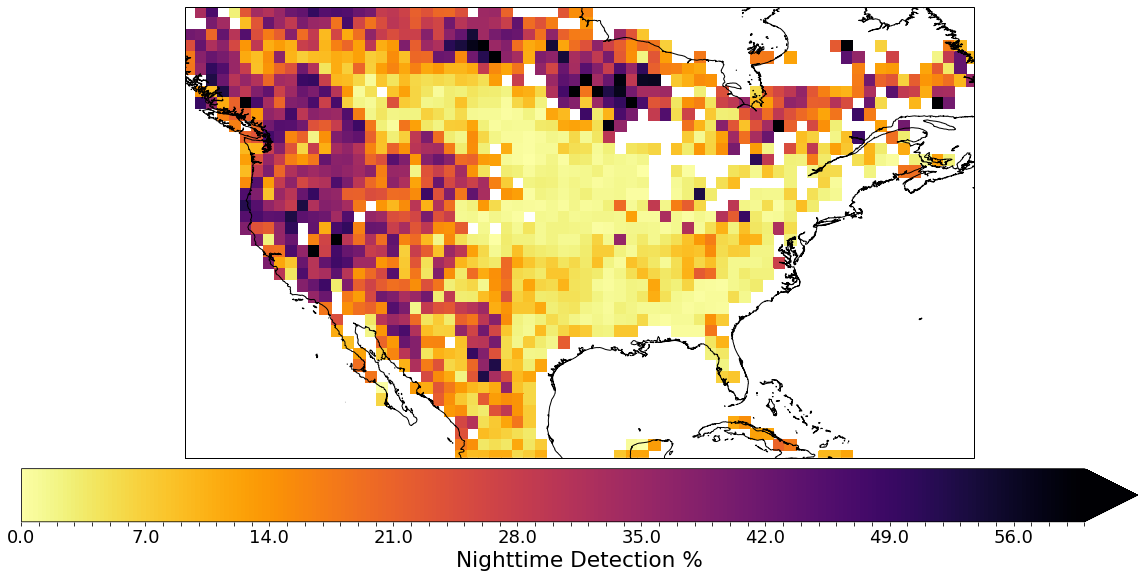

In [32]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# large map
# ax = plt.subplot(1,3,(2,3), projection=ccrs.EqualEarth(central_longitude=180))
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='10m')


#del cmap
# try function
c = 'viridis_r'
c = 'inferno_r'
#cmap, bounds = discrete_cmap(20, c)

base = plt.cm.get_cmap(c)
z_t_1_fact = 0.01
bounds = np.arange(0,1,z_t_1_fact)
print(bounds, bounds.shape)
color_list = base(bounds)
N = bounds.shape[0]
cmap_name = base.name + str(N)

# if  'viridis' in c:
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)
# else:
#     cmap = base.from_list(cmap_name, color_list, N)
    
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, color_list, N)


# cf4 = xdata_gl.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm, add_colorbar=False, extend='neither')
cf4 = xdata_gl.plot(ax=ax, vmax=0.6, transform=ccrs.PlateCarree(), cmap='inferno_r',  add_colorbar=False, extend='max')
ax.set_ylim(-60, 75)

#CONUS 24.126701958681668, 51.12421275782688, -128.759765625, -66.26953125
ax.set_ylim(20, 60)
ax.set_xlim(-130., -60.)

# ax.set_title('NIGHTTIME %')

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    boundaries=bounds,
#                    cmap=cmap,
#                    norm=norm,
#                    ticks=bounds)

# cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02, 
#                    cmap=cmap,
#                    ticks=bounds,
#                   extend='max')

cb4 = fig.colorbar(cf4, ax=ax, orientation='horizontal', shrink=1.0, pad=0.02,
                  extend='max',
                  ticks=bounds[bounds<=0.6])

# show as percentage
cb4.ax.set_xticklabels(['{0:.1f}'.format(b*100) for b in bounds[bounds<=0.6]], rotation=0)

if bounds.shape[0] > 10:
       
    n = 7  # Keeps every 7th label
    [l.set_visible(False) for (i,l) in enumerate(cb4.ax.xaxis.get_ticklabels()) if i % n != 0]
    
cb4.set_label('Nighttime Detection %', size='large')

plt.tight_layout()
plt.savefig(f'C:/users/jomc9287/desktop/extend_NOgldasmask_burnable_{c}_fullOC_CONUS.png')
plt.show()

In [3]:
import numpy as np
a = np.array([[
              -128.759765625,
              24.126701958681668
            ],
            [
              -66.26953125,
              24.126701958681668
            ],
            [
              -66.26953125,
              51.12421275782688
            ],
            [
              -128.759765625,
              51.12421275782688
            ],
            [
              -128.759765625,
              24.126701958681668
            ]])
a.shape
a[:,0].min(), a[:,0].max(), a[:,1].min(), a[:,1].max()

(-128.759765625, -66.26953125, 24.126701958681668, 51.12421275782688)

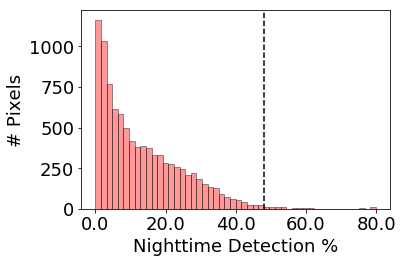

In [28]:
fig, ax = plt.subplots()
histbins = ax.hist(xdata_gl.values.ravel(), bins=50, alpha=0.4, edgecolor='k', facecolor='r')
ax.set_xlabel('Nighttime Detection %')
ax.set_ylabel('# Pixels')
ax.axvline(0.6, 0, 1200, c='k', linestyle='--')

# run these next 2 lines in a different cell if there is an error..
# new_xticks=['{0:.1f}'.format(float(t.get_text())*100) for t in xticks[1:]]
# new_xticks = [xticks[0].get_text()] + new_xticks
new_xticks=['{0:.1f}'.format(float(t)*100) for t in ax.get_xticks()[1:]]
new_xticks = [ax.get_xticks()[0]] + new_xticks

ax.set_xticklabels(new_xticks)

plt.tight_layout()
plt.savefig(f'C:/users/jomc9287/desktop/nighttime_det_perc_threshold.png')
plt.show()

In [29]:
xdata_gl.values[xdata_gl.values > 0.6].size, xdata_gl.values[~np.isnan(xdata_gl.values)].size

(72, 9411)

In [30]:
72/9411

0.007650621613006056

In [31]:
# get values above 25%
xdata_gl.values[xdata_gl.values > 0.25].size, xdata_gl.values[~np.isnan(xdata_gl.values)].size

(2368, 9411)

In [32]:
2368/9411

0.2516204441610881

In [33]:
hfp_fi = '../hfp-global-geo-grid/hf_v2geo_1_0deg.tif'
with rio.open(hfp_fi) as src:
    hfp_prof = src.profile
    hfp_arr = src.read(1)
    hfp_arr = np.ma.masked_less(hfp_arr, 0)
    
print(hfp_prof)
xr_hfp = xr.open_rasterio(hfp_fi)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 360, 'height': 155, 'count': 1, 'crs': CRS.from_dict(init='epsg:4008'), 'transform': Affine(0.9999996, 0.0, -180.0,
       0.0, -0.9999996, 89.76428993520813), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}


In [34]:
xdata_gl.shape, xr_hfp.shape

((181, 360), (1, 155, 360))

In [36]:
hfp_xdata = xdata_gl.values[:155,:]
hfp_xdata.shape

(155, 360)

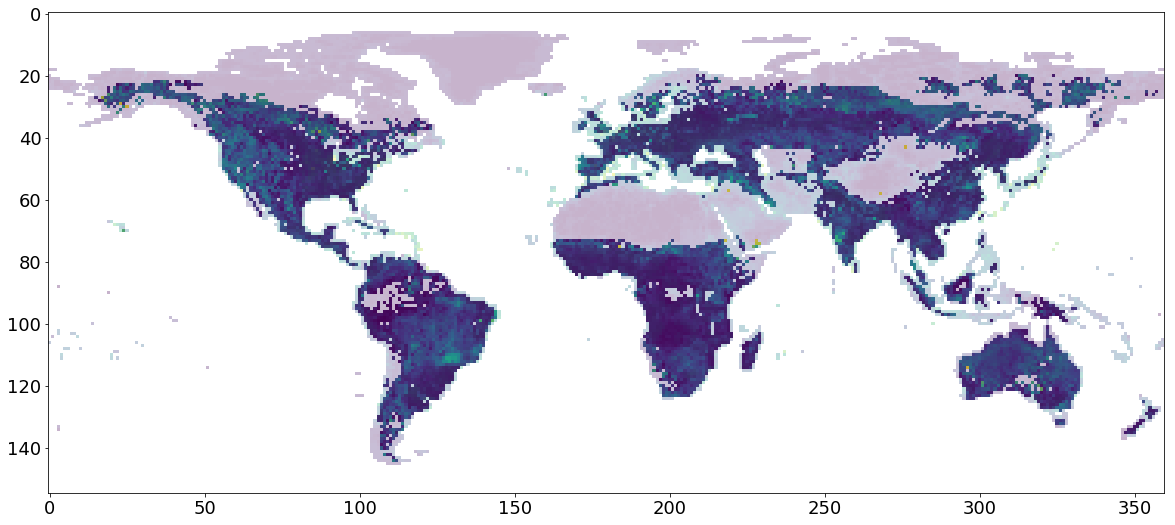

In [37]:
plt.figure(figsize=(20,10))
plt.imshow(hfp_xdata)
plt.imshow(hfp_arr, alpha=0.3)
plt.show()

At the quarter-degree grid level (hfp_scatter_nperc_0_25degree.png), can you calculate a few numbers for me. 
* Mean (+/- SD) percent nighttime detections for HFI less than 50 and more than 50. 
* mean (+/- SD) for HFI 0-25; 25-50; 50-75; and 75-100. 

And can you only include the 11 landcovers in these calculations. I think this figure will end up in a supplement. Thanks!

In [45]:
# xdata for 0.25 degree
print(agg)

data = perc_night_total
agg_fact=1
template = glob(raster_folder + '{}/*_D_*{}*.tif'.format('AFC_num', 'April'))[0]
with rio.open(template) as src:
    meta = src.meta

tform = meta['transform']
#num_x = meta['width']
#num_y = meta['height']

num_x = data.shape[1]
num_y = data.shape[0]

# incorporate aggregation factor
tlon = np.linspace(tform.c - tform.a*agg_fact, tform.c+num_x*tform.a*agg_fact, num_x)
tlat = np.linspace(tform.f - tform.e*agg_fact, tform.f+num_y*tform.e*agg_fact, num_y)
lon2d, lat2d = np.meshgrid(tlon, tlat)


# make data into xarray with location
xdata = xr.DataArray(data, coords=[tlat, tlon], dims=['lat', 'lon'])
xdata = xr.where(xdata == 0, np.nan, xdata)
print(xdata.shape)



gldas_fi = '../GLDAS/GLDASp4_domveg_025d.tif'
with rio.open(gldas_fi) as src:
    gldas_prof = src.profile
    gldas_arr = src.read(1)
    
xr_gldas = xr.open_rasterio(gldas_fi)

gldas_burn_cond = (gldas_arr==0) | \
             (gldas_arr==13) | (gldas_arr==15) | (gldas_arr==16) | \
             (gldas_arr==18) | (gldas_arr==19) | (gldas_arr==20) 

# Max's palette
gldas_burn_cond = (gldas_arr==0) | (gldas_arr==3) | (gldas_arr==11) | (gldas_arr==13) | (gldas_arr>=15)

# gldas_mask = np.where((gldas_arr==0) | (gldas_arr==12) | (gldas_arr==14), 0, 1)
gldas_mask = np.where(gldas_burn_cond, 0, 1)
gl_nc = xdata.values[:gldas_arr.shape[0],:].copy()

gl_nc_mask = gl_nc * gldas_mask
gl_nc.shape, gldas_mask.shape, gldas_arr.shape

hfp_fi = '../hfp-global-geo-grid/hf_v2geo_0_25deg.tif'
with rio.open(hfp_fi) as src:
    hfp_prof = src.profile
    hfp_arr = src.read(1)
    hfp_arr = np.ma.masked_less(hfp_arr, 0)
    
print(hfp_prof)
xr_hfp = xr.open_rasterio(hfp_fi)

# use only GLDAS pixels
hfp_gl = hfp_arr[:gldas_arr.shape[0],:]

4
(721, 1440)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1440, 'height': 620, 'count': 1, 'crs': CRS.from_dict(init='epsg:4008'), 'transform': Affine(0.2499999, 0.0, -180.0,
       0.0, -0.2499999, 89.76428993520813), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'interleave': 'band'}


In [58]:
# Mean (+/- SD) percent nighttime detections for HFI less than 50 and more than 50
cond = hfp_gl<50
lt50_mean = np.nanmean(gl_nc[cond])
lt50_std = np.nanstd(gl_nc[cond])
print(f'mean n% HFI lt 50: {lt50_mean:0.3f} ({lt50_mean-lt50_std:0.3f}/{lt50_mean+ lt50_std:0.3f}), std={lt50_std:0.3f}')

cond = hfp_gl>50
gt50_mean = np.nanmean(gl_nc[cond])
gt50_std = np.nanstd(gl_nc[cond])
print(f'mean n% HFI gt 50: {gt50_mean:0.3f} ({gt50_mean-gt50_std:0.3f}/{gt50_mean+ gt50_std:0.3f}), std={gt50_std:0.3f}')

# mean (+/- SD) for HFI 0-25; 
cond = (hfp_gl>0) & (hfp_gl<=25)
h0_25_mean = np.nanmean(gl_nc[cond])
h0_25_std = np.nanstd(gl_nc[cond])
print(f'mean n% HFI (0,25]: {h0_25_mean:0.3f} ({h0_25_mean-h0_25_std:0.3f}/{h0_25_mean+ h0_25_std:0.3f}), std={h0_25_std:0.3f}')

# mean (+/- SD) for HFI 25-50; 
cond = (hfp_gl>25) & (hfp_gl<=50)
h25_50_mean = np.nanmean(gl_nc[cond])
h25_50_std = np.nanstd(gl_nc[cond])
print(f'mean n% HFI (25,50]: {h25_50_mean:0.3f} ({h25_50_mean-h25_50_std:0.3f}/{h25_50_mean+ h25_50_std:0.3f}), std={h25_50_std:0.3f}')

# mean (+/- SD) for HFI 50-75;
cond = (hfp_gl>50) & (hfp_gl<=75)
h50_75_mean = np.nanmean(gl_nc[cond])
h50_75_std = np.nanstd(gl_nc[cond])
print(f'mean n% HFI (50,75]: {h50_75_mean:0.3f} ({h50_75_mean-h50_75_std:0.3f}/{h50_75_mean+ h50_75_std:0.3f}), std={h50_75_std:0.3f}')

# mean (+/- SD) for HFI 75-100.
cond = (hfp_gl>75) & (hfp_gl<=100)
h75_100_mean = np.nanmean(gl_nc[cond])
h75_100_std = np.nanstd(gl_nc[cond])
print(f'mean n% HFI (75,100]: {h75_100_mean:0.3f} ({h75_100_mean-h75_100_std:0.3f}/{h75_100_mean+ h75_100_std:0.3f}), std={h75_100_std:0.3f}')


mean n% HFI lt 50: 0.189 (-0.007/0.384), std=0.196
mean n% HFI gt 50: 0.172 (-0.026/0.369), std=0.197
mean n% HFI (0,25]: 0.219 (0.015/0.423), std=0.204
mean n% HFI (25,50]: 0.127 (-0.032/0.287), std=0.160
mean n% HFI (50,75]: 0.167 (-0.025/0.359), std=0.192
mean n% HFI (75,100]: 0.241 (-0.010/0.492), std=0.251


In [44]:
gldas_arr.shape, hfp_arr.shape

((600, 1440), (620, 1440))